# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch - Now Using UA SWE Data 


This notebook is a slightly modified version of the protoype model provided to the Frosty Dawgs team, demonstrating an LSTM model to predict SWE on several Huc10 units in Skagit Basin.  It represents the starting point for the team's work and we thank the authors of the original prototype model.  

This notebook modifies the original noebook by chainging the data source to use a longer time series of data (UA data).  Additional modifications include: (1) adds a KGE goodness of fit metric, (2) adds ML Flow tracking capabilities and (3) normalizes the UA data prior to model training. 

First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from snowML import data_utils as du

from torch import nn
#from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

##  Set the MLflow tracking server

Note: Assumes you have already started mlflow by opening a terminal withy mlflow installed and running mlflow uo

In [2]:
# Set our tracking server uri for logging
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"
mlflow.set_tracking_uri(tracking_uri)

# Create a new MLflow Experiment called "LSTM"
mlflow.set_experiment("ProtoType_Results")

<Experiment: artifact_location='s3://sues-test/199', creation_time=1740199897768, experiment_id='199', last_update_time=1740199897768, lifecycle_stage='active', name='ProtoType_Results', tags={}>

## Data Prepration 

In [3]:
# This function loads the model ready data for a given huc number

def get_dogs_data(huc_list, var_list):
    bucket_name = "snowml-model-ready"
    df_dict = {}  # Initialize dictionary
    for huc in huc_list: 
        file_name = f"model_ready_huc{huc}.csv"
        df = du.s3_to_df(file_name, bucket_name)
        df['day'] = pd.to_datetime(df['day'])
        df.set_index('day', inplace=True)  # Set 'day' as the index
        df = df[var_list]
        df_dict[huc] = df  # Store DataFrame in dictionary
    return df_dict


In [4]:
huc_list = [1711000504, 1711000505, 1711000506, 1711000507, 1711000508, 1711000509, 1711000511]
var_list = ["mean_pr", "mean_tair", "mean_swe"]
df_dict = get_dogs_data(huc_list, var_list)
# display an example 
df = df_dict[1711000506]
df.head(2)

,mean_pr,mean_tair,mean_swe
day,,,
1983-10-01,0.0,4.683,0.0
1983-10-02,0.0,5.416,0.0


In [5]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
    normalized_df = df.copy()

    for column in ["mean_pr", "mean_tair"]:
        column_mean = df[column].mean()
        column_std = df[column].std()
        normalized_df[column] = (df[column] - column_mean) / column_std

    return normalized_df

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [6]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :2].values  # Select first two columns
        target = dataset.iloc[i + lookback, -1:].values  # Selects the last column dynamically
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
def train_test_split(data, train_size_fraction):
    train_size_main = int(len(data) * train_size_fraction)
    test_size_main = len(data) - train_size_main
    train_main, test_main = data[:train_size_main], data[train_size_main:]
    return train_main, test_main, train_size_main, test_size_main

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting mean_swe values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [8]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

In [9]:
class KGE_Loss(nn.Module):
    def __init__(self, eps=1e-6):
        super(KGE_Loss, self).__init__()
        self.eps = eps  # Small constant for numerical stability

    def forward(self, pred, obs):
        # Ensure tensors are at least 1D
        if pred.ndim == 0 or obs.ndim == 0:
            return torch.tensor(float("nan"), device=pred.device)

        obs_mean = torch.mean(obs)
        pred_mean = torch.mean(pred)

        obs_std = torch.std(obs) + self.eps  # Avoid division by zero
        pred_std = torch.std(pred) + self.eps

        # Compute Pearson correlation manually to avoid `torch.corrcoef` issues
        covariance = torch.mean((pred - pred_mean) * (obs - obs_mean))
        r = covariance / (obs_std * pred_std + self.eps)  # Avoid zero denominator

        # Ensure r is within valid range for correlation (due to numerical errors)
        r = torch.clamp(r, -1 + self.eps, 1 - self.eps)

        alpha = pred_std / obs_std  # Standard deviation ratio
        beta = pred_mean / (obs_mean + self.eps)  # Mean ratio

        # Compute KGE
        kge = 1 - torch.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

        # Ensure loss is finite
        if torch.isnan(kge) or torch.isinf(kge):
            return torch.tensor(float("nan"), device=pred.device)

        return -kge  # Negative KGE for loss minimization


# loss_fn_snotel = KGE_Loss()


## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. 

In [10]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
	loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
	epoch_losses = []

	for epoch in  range(n_epochs):
		epoch_loss = 0.0
		model.train()
		for X_batch, y_batch in loader:
			y_pred = model(X_batch)
			loss = loss_fn(y_pred, y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		# Validation
		#if epoch % 10 != 0:
			#continue

		model.eval()

		with torch.no_grad():
			y_pred = model(X_train)
			train_loss = loss_fn(y_pred, y_train)
			print(f"Epoch {epoch}: train loss {train_loss:.4f}")

		epoch_losses.append(epoch_loss / len(loader))

	return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual mean_swe values.



In [11]:
def predict(data, model, X_train,X_test, lookback, train_size, huc_no):
    data = data.astype(object)
    with torch.no_grad():
        train_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        y_pred = model(X_train)
        print(y_pred.shape)
        y_pred_new = y_pred[:,  -1].unsqueeze(1)
        print(y_pred_new.shape)
        print(type(lookback),type(train_size))
        train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))  # Create figure explicitly
    ax.plot(data.index, data['mean_swe'], c='b', label='Actual')
    ax.plot(data.index, train_plot, c='r', label='Train Predictions')
    ax.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('mean_swe')
    ttl = f"UAData_SWE_Post_Predictions_for_huc_{huc_no}"
    ax.set_title(ttl)
    plt.show()

    fig.savefig(f"{ttl}.png", bbox_inches='tight')
    mlflow.log_artifact(f"{ttl}.png")
    plt.close(fig)

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2). In addition, Kling-gupta-efficiency (KGE) added by the Frosty Dawgs team. 

In [12]:
def kling_gupta_efficiency(y_true, y_pred):
    r = np.corrcoef(y_true.ravel(), y_pred.ravel())[0, 1] # Correlation coefficient
    alpha = np.std(y_pred) / np.std(y_true)  # Variability ratio
    beta = np.mean(y_pred) / np.mean(y_true)  # Bias ratio
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    #print(f"r: {r}, alpha: {alpha}, beta: {beta}")
    return kge

In [13]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
    train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
    test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
    train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
    test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

    test_kge = kling_gupta_efficiency(y_test.numpy(), y_test_pred.numpy())  
    train_kge = kling_gupta_efficiency(y_train.numpy(), y_train_pred.numpy())  

    return [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2, train_kge, test_kge]


In [14]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.5173
Epoch 1: train loss -0.7618
Epoch 2: train loss -0.7931
Epoch 3: train loss -0.8951
Epoch 4: train loss -0.8852
Epoch 5: train loss -0.8701
Epoch 6: train loss -0.9293
Epoch 7: train loss -0.9491
Epoch 8: train loss -0.9650
Epoch 9: train loss 0.0444
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


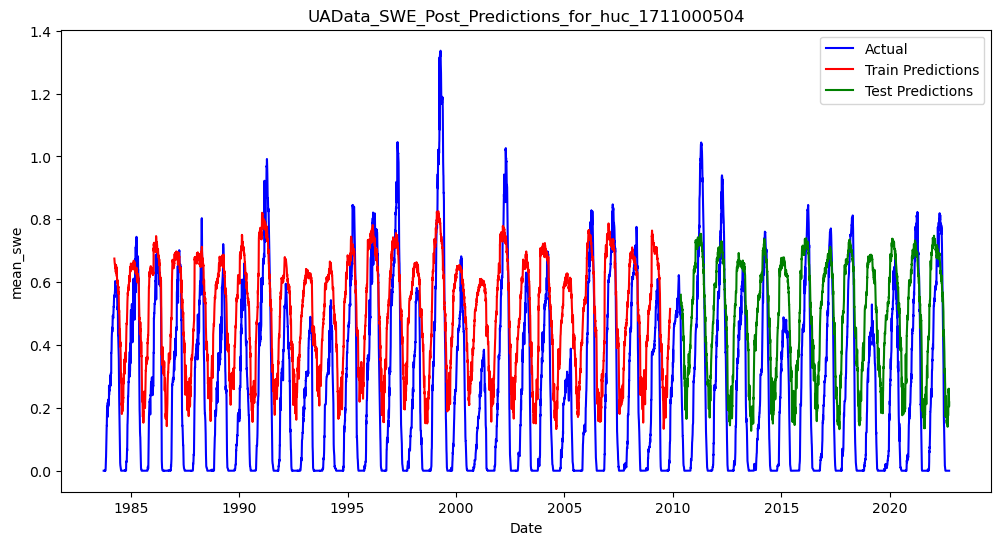

[0.087086745, 0.08214677, 0.2679593, 0.25741535, -0.11040842533111572, -0.034276723861694336, -0.04439017140620827, 0.027896381188107666]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.087087      183.068706
1       180  snotel   test_mse  0.082147      183.068706
2       180  snotel  train_mae  0.267959      183.068706
3       180  snotel   test_mae  0.257415      183.068706
4       180  snotel   train_r2 -0.110408      183.068706
5       180  snotel    test_r2 -0.034277      183.068706
6       180  snotel  train_kge -0.044390      183.068706
7       180  snotel   test_kge  0.027896      183.068706
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9163
Epoch 1: train loss -0.9478
Epoch 2: train loss -0.9441
Epoch 3: train loss -0.9542
Epoch 4: train loss -0.9643
Epoch 5: train loss -0.9744
Epoch 6: train loss -0.9703
Epoch 7: train loss -0.9510
Epoch 8: train loss -0.9197
Epoch 9: train

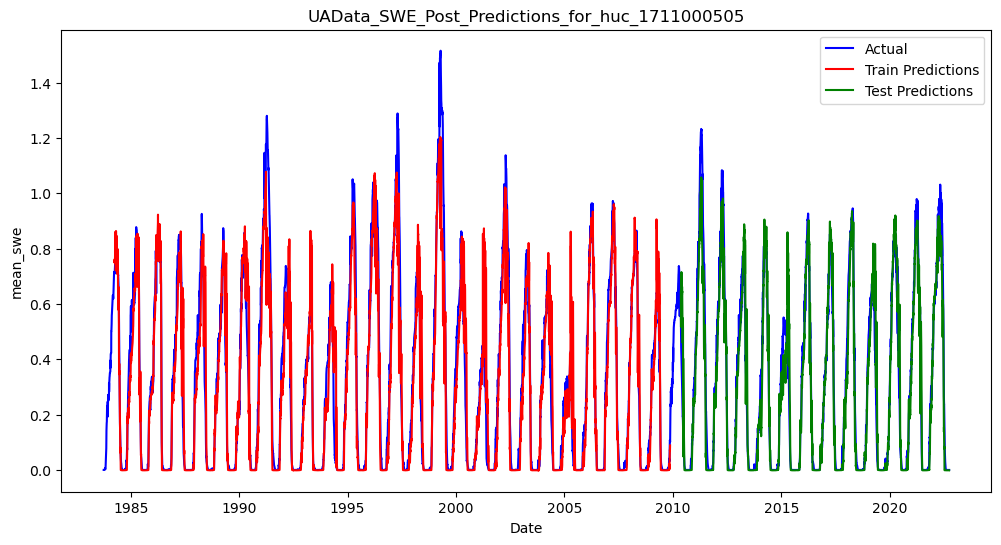

[0.01271718, 0.008631462, 0.06550671, 0.054277107, 0.8867416977882385, 0.9178003072738647, 0.8855451642045272, 0.9220062434984079]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.012717      166.560909
1       180  snotel   test_mse  0.008631      166.560909
2       180  snotel  train_mae  0.065507      166.560909
3       180  snotel   test_mae  0.054277      166.560909
4       180  snotel   train_r2  0.886742      166.560909
5       180  snotel    test_r2  0.917800      166.560909
6       180  snotel  train_kge  0.885545      166.560909
7       180  snotel   test_kge  0.922006      166.560909
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.8825
Epoch 1: train loss -0.9359
Epoch 2: train loss -0.9223
Epoch 3: train loss -0.9247
Epoch 4: train loss -0.8008
Epoch 5: train loss -0.8896
Epoch 6: train loss -0.8724
Epoch 7: train loss -0.9327
Epoch 8: train loss -0.9370
Epoch 9: train loss -

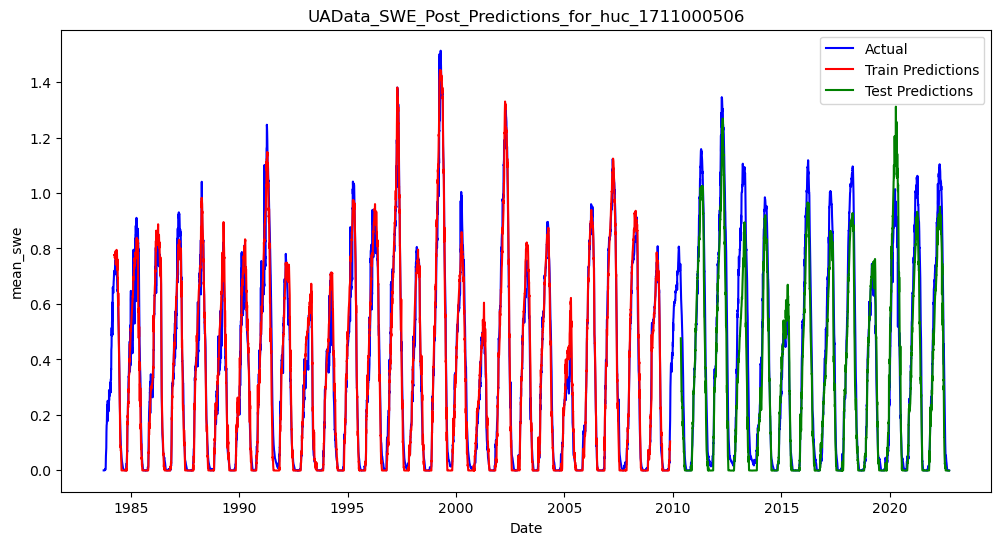

[0.0035990726, 0.014295536, 0.040572274, 0.08226104, 0.9682444334030151, 0.9008809328079224, 0.9672552022227183, 0.8258056671385092]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.003599      175.804677
1       180  snotel   test_mse  0.014296      175.804677
2       180  snotel  train_mae  0.040572      175.804677
3       180  snotel   test_mae  0.082261      175.804677
4       180  snotel   train_r2  0.968244      175.804677
5       180  snotel    test_r2  0.900881      175.804677
6       180  snotel  train_kge  0.967255      175.804677
7       180  snotel   test_kge  0.825806      175.804677
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9008
Epoch 1: train loss -0.9364
Epoch 2: train loss -0.9552
Epoch 3: train loss -0.9809
Epoch 4: train loss -0.9828
Epoch 5: train loss -0.9601
Epoch 6: train loss -0.9677
Epoch 7: train loss -0.9854
Epoch 8: train loss -0.9096
Epoch 9: train loss

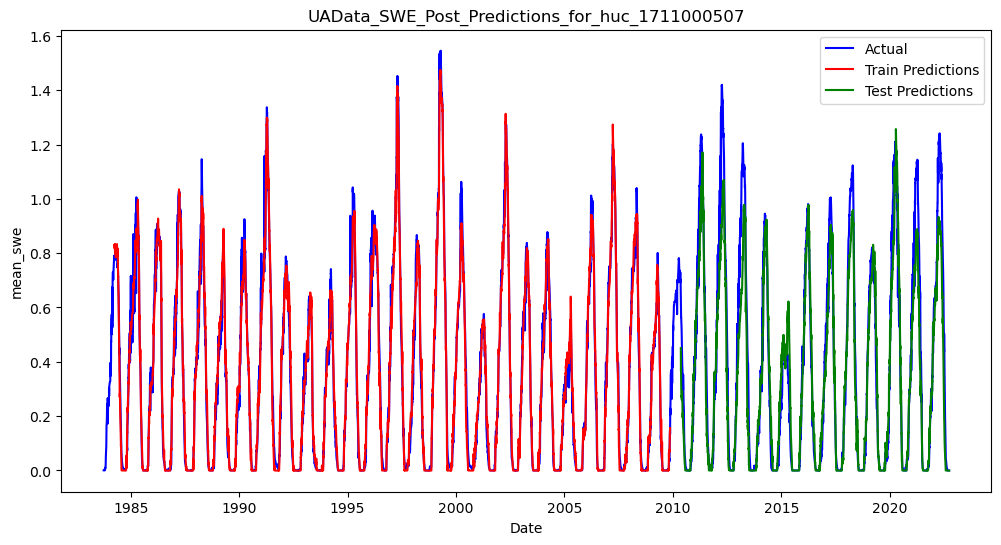

[0.0020474514, 0.01422913, 0.030906927, 0.0774008, 0.9828388690948486, 0.9052835702896118, 0.9734887361645999, 0.8167785059010835]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.002047      164.978787
1       180  snotel   test_mse  0.014229      164.978787
2       180  snotel  train_mae  0.030907      164.978787
3       180  snotel   test_mae  0.077401      164.978787
4       180  snotel   train_r2  0.982839      164.978787
5       180  snotel    test_r2  0.905284      164.978787
6       180  snotel  train_kge  0.973489      164.978787
7       180  snotel   test_kge  0.816779      164.978787
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9643
Epoch 1: train loss -0.9835
Epoch 2: train loss -0.9837
Epoch 3: train loss -0.9302
Epoch 4: train loss -0.9789
Epoch 5: train loss -0.9153
Epoch 6: train loss -0.9751
Epoch 7: train loss -0.9690
Epoch 8: train loss -0.9818
Epoch 9: train loss -

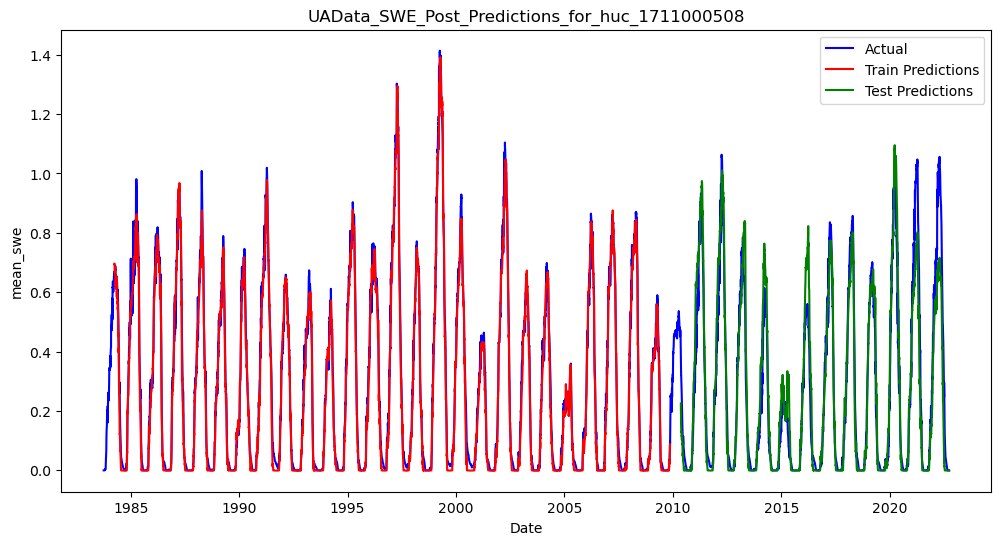

[0.0010720139, 0.007731028, 0.02303328, 0.055932187, 0.9886695146560669, 0.9145746827125549, 0.9462615102755982, 0.9536346202801687]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.001072      174.509269
1       180  snotel   test_mse  0.007731      174.509269
2       180  snotel  train_mae  0.023033      174.509269
3       180  snotel   test_mae  0.055932      174.509269
4       180  snotel   train_r2  0.988670      174.509269
5       180  snotel    test_r2  0.914575      174.509269
6       180  snotel  train_kge  0.946262      174.509269
7       180  snotel   test_kge  0.953635      174.509269
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9636
Epoch 1: train loss -0.9512
Epoch 2: train loss -0.9472
Epoch 3: train loss -0.9814
Epoch 4: train loss -0.9825
Epoch 5: train loss -0.9181
Epoch 6: train loss -0.9702
Epoch 7: train loss -0.9860
Epoch 8: train loss -0.9779
Epoch 9: train loss

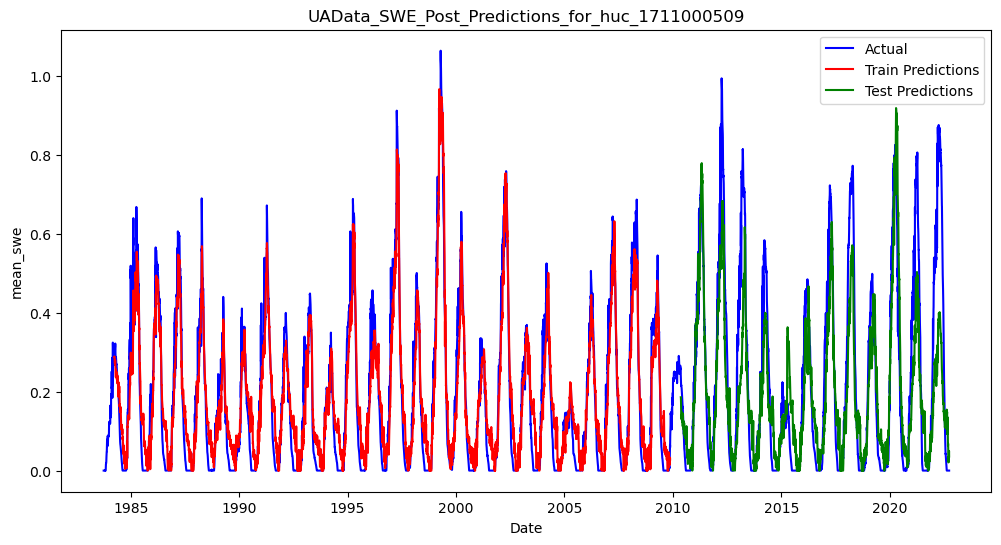

[0.0039353934, 0.019594466, 0.050146814, 0.09920012, 0.8977692723274231, 0.6942310333251953, 0.8324087195566097, 0.6337601874137078]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.003935      174.891053
1       180  snotel   test_mse  0.019594      174.891053
2       180  snotel  train_mae  0.050147      174.891053
3       180  snotel   test_mae  0.099200      174.891053
4       180  snotel   train_r2  0.897769      174.891053
5       180  snotel    test_r2  0.694231      174.891053
6       180  snotel  train_kge  0.832409      174.891053
7       180  snotel   test_kge  0.633760      174.891053
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.8776
Epoch 1: train loss -0.9843
Epoch 2: train loss -0.9657
Epoch 3: train loss -0.9662
Epoch 4: train loss -0.9907
Epoch 5: train loss -0.8778
Epoch 6: train loss -0.8814
Epoch 7: train loss -0.9424
Epoch 8: train loss -0.9333
Epoch 9: train loss

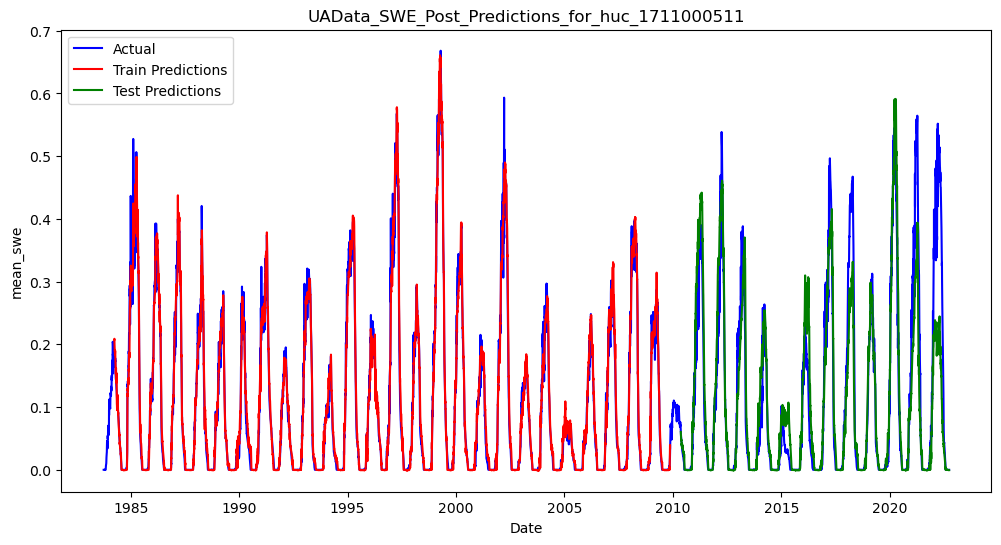

[0.0002911834, 0.0043295757, 0.010599712, 0.03672755, 0.982520580291748, 0.8094010353088379, 0.9679864940197412, 0.8337445881181854]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000291      168.716356
1       180  snotel   test_mse  0.004330      168.716356
2       180  snotel  train_mae  0.010600      168.716356
3       180  snotel   test_mae  0.036728      168.716356
4       180  snotel   train_r2  0.982521      168.716356
5       180  snotel    test_r2  0.809401      168.716356
6       180  snotel  train_kge  0.967986      168.716356
7       180  snotel   test_kge  0.833745      168.716356
🏃 View run gifted-rat-577 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199/runs/fd28631989ce491198c872dea28deab9
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199


In [15]:
# Define the hyperparameters
input_size=2
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 10
train_size_fraction = 0.67
lookback_values =  [180]


with mlflow.start_run():
    # log all the params
    mlflow.log_param("Training From", "Prototype Notebook")
    mlflow.log_param("Data Source", "UA SWE Data")
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_class", num_class)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_size_fraction", train_size_fraction)
    mlflow.log_param("lookback_values", lookback_values)
    mlflow.log_param("epochs", n_epochs) 
    

    model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
    optimizer_snotel = optim.Adam(model_snotel.parameters())
    #loss_fn_snotel = nn.MSELoss()
    loss_fn_snotel = KGE_Loss()
    mlflow.log_param("loss_function", loss_fn_snotel)
    

    for huc_no in huc_list: 
        # Get the model ready data 
        data = df_dict[(huc_no)]
        data = z_score_normalize(data)
        print(f"NA datais {data.isna().sum()}")
        data = data.fillna(method='bfill')
        train_main, test_main, train_size_main, test_size_main = train_test_split(data, train_size_fraction)

        # Usage example
        lookback_values =  [180]
        results = []

        for lookback in lookback_values:
            print(f"\nLookback: {lookback}")
            start_time = time.time()

            # Snotel dataset
            X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
            X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)

            train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=n_epochs, batch_size=8) 
            predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main, huc_no)
            snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
            print(snotel_metrics)
            elapsed_time = time.time() - start_time

            results.append([lookback, 'snotel', 'train_mse', snotel_metrics[0], elapsed_time])
            results.append([lookback, 'snotel', 'test_mse', snotel_metrics[1], elapsed_time])
            results.append([lookback, 'snotel', 'train_mae', snotel_metrics[2], elapsed_time])
            results.append([lookback, 'snotel', 'test_mae', snotel_metrics[3], elapsed_time])
            results.append([lookback, 'snotel', 'train_r2', snotel_metrics[4], elapsed_time])
            results.append([lookback, 'snotel', 'test_r2', snotel_metrics[5], elapsed_time])
            results.append([lookback, 'snotel', 'train_kge', snotel_metrics[6], elapsed_time])
            results.append([lookback, 'snotel', 'test_kge', snotel_metrics[7], elapsed_time])

            
            mlflow.log_metric(f"{huc_no}_train_mse", snotel_metrics[0])
            mlflow.log_metric(f"{huc_no}_test_mse", snotel_metrics[1])
            mlflow.log_metric(f"{huc_no}_train_kge", snotel_metrics[6])
            mlflow.log_metric(f"{huc_no}_test_kge", snotel_metrics[7])

        


        # Create a DataFrame for the results
        df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])

        # Print the DataFrame
        print(df_results)